In [ ]:
import random
from pathlib import Path

import numpy as np
from ase.db import connect

random.seed(0)

# DATA_DIR = Path("../../examples/c2db/")
DATA_DIR = Path(".")

db = connect(DATA_DIR / "c2db.db")
random_indices = random.sample(range(1, len(db) + 1), 1000)


In [ ]:
import itertools

import pandas as pd
import phonopy
from tqdm.auto import tqdm

from mlip_arena.models import MLIPEnum

for row, model in tqdm(
    itertools.product(db.select(filter=lambda r: r["id"] in random_indices), MLIPEnum)
):
    uid = row["uid"]

    if Path(f"{model.name}.parquet").exists():
        df = pd.read_parquet(f"{model.name}.parquet")
        if uid in df["uid"].unique():
            continue
    else:
        df = pd.DataFrame(columns=["model", "uid", "eigenvalues", "frequencies"])

    try:
        path = Path(model.name) / uid
        phonon = phonopy.load(path / "phonopy.yaml")
        frequencies = phonon.get_frequencies(q=(0, 0, 0))

        data = np.load(path / "elastic.npz")

        eigenvalues = data["eigenvalues"]

        new_row = pd.DataFrame(
            [
                {
                    "model": model.name,
                    "uid": uid,
                    "eigenvalues": eigenvalues,
                    "frequencies": frequencies,
                }
            ]
        )

        df = pd.concat([df, new_row], ignore_index=True)
        df.drop_duplicates(subset=["model", "uid"], keep="last", inplace=True)

        df.to_parquet(f"{model.name}.parquet", index=False)
    except Exception:
        pass


0it [00:00, ?it/s]

In [6]:
uids = []
stabilities = []
for row in db.select(filter=lambda r: r["id"] in random_indices):
    stable = row.key_value_pairs["dyn_stab"]
    if stable.lower() == "unknown":
        stable = None
    else:
        stable = True if stable.lower() == "yes" else False
    uids.append(row.key_value_pairs["uid"])
    stabilities.append(stable)


stabilities = np.array(stabilities)

(stabilities == True).sum(), (stabilities == False).sum(), (stabilities == None).sum()

(287, 218, 495)

/tmp/ipykernel_1565723/4252017719.py:76: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_pred = sorted_df['dyn_stab'][mask].fillna(-1).astype('int')
/tmp/ipykernel_1565723/4252017719.py:76: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_pred = sorted_df['dyn_stab'][mask].fillna(-1).astype('int')


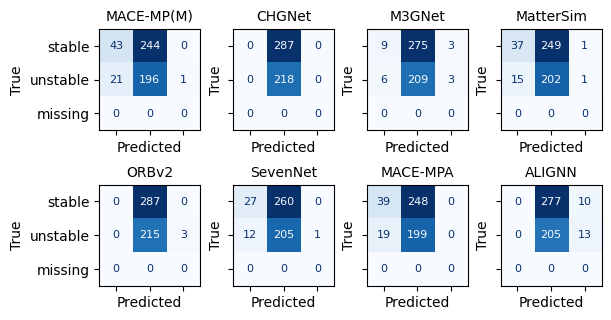

In [104]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics import (
    ConfusionMatrixDisplay,
    classification_report,
    confusion_matrix,
)

from mlip_arena.models import MLIPEnum

thres = -1e-7

select_models = [
    "ALIGNN",
    "CHGNet",
    "M3GNet",
    "MACE-MP(M)",
    "MACE-MPA",
    "MatterSim",
    "ORBv2",
    "SevenNet",
]

with plt.style.context("default"):
    # plt.rcParams.update({
    #     # "title.fontsize": 10,
    #     "axes.titlesize": 10,
    #     "axes.labelsize": 8,
    # })

    SMALL_SIZE = 8
    MEDIUM_SIZE = 10
    BIGGER_SIZE = 12
    plt.rcParams.update(
        {
            "font.size": SMALL_SIZE,
            "axes.titlesize": MEDIUM_SIZE,
            "axes.labelsize": MEDIUM_SIZE,
            "xtick.labelsize": MEDIUM_SIZE,
            "ytick.labelsize": MEDIUM_SIZE,
            "legend.fontsize": SMALL_SIZE,
            "figure.titlesize": BIGGER_SIZE,
        }
    )

    fig, axs = plt.subplots(
        nrows=int(np.ceil(len(MLIPEnum) / 4)),
        ncols=4,
        figsize=(6, 3 * int(np.ceil(len(select_models) / 4))),
        sharey=True,
        sharex=True,
        layout="constrained",
    )
    axs = axs.flatten()
    plot_idx = 0

    for model in MLIPEnum:
        fpath = DATA_DIR / f"{model.name}.parquet"
        if not fpath.exists():
            continue

        if model.name not in select_models:
            continue

        df = pd.read_parquet(fpath)
        df["eigval_min"] = df["eigenvalues"].apply(
            lambda x: x.min() if np.isreal(x).all() else thres
        )
        df["freq_min"] = df["frequencies"].apply(
            lambda x: x.min() if np.isreal(x).all() else thres
        )
        df["dyn_stab"] = ~np.logical_or(
            df["eigval_min"] < thres, df["freq_min"] < thres
        )

        arg = np.argsort(uids)
        uids_sorted = np.array(uids)[arg]
        stabilities_sorted = stabilities[arg]

        sorted_df = (
            df[df["uid"].isin(uids_sorted)].set_index("uid").reindex(uids_sorted)
        )
        mask = ~(stabilities_sorted == None)

        y_true = stabilities_sorted[mask].astype("int")
        y_pred = sorted_df["dyn_stab"][mask].fillna(-1).astype("int")
        cm = confusion_matrix(y_true, y_pred, labels=[1, 0, -1])

        ax = axs[plot_idx]
        ConfusionMatrixDisplay(
            cm, display_labels=["stable", "unstable", "missing"]
        ).plot(ax=ax, cmap="Blues", colorbar=False)

        ax.set_title(model.name)
        ax.set_xlabel("Predicted")
        ax.set_ylabel("True")
        ax.set_xticks([0, 1, 2])
        ax.set_xticklabels(["stable", "unstable", "missing"])
        ax.set_yticks([0, 1, 2])
        ax.set_yticklabels(["stable", "unstable", "missing"])

        plot_idx += 1

    # Hide unused subplots
    for i in range(plot_idx, len(axs)):
        fig.delaxes(axs[i])

    # plt.tight_layout()
    plt.savefig("c2db-confusion_matrices.pdf", bbox_inches="tight")
    plt.show()


In [52]:
import pandas as pd
from sklearn.metrics import confusion_matrix

from mlip_arena.models import MLIPEnum

thres = -1e-7

summary_df = pd.DataFrame(columns=["Model", "Stable F1", "Unstable F1", "Weighted F1"])

for model in MLIPEnum:
    fpath = DATA_DIR / f"{model.name}.parquet"

    if not fpath.exists() or model.name not in select_models:
        # print(f"File {fpath} does not exist")
        continue
    df = pd.read_parquet(fpath)

    df["eigval_min"] = df["eigenvalues"].apply(
        lambda x: x.min() if np.isreal(x).all() else thres
    )
    df["freq_min"] = df["frequencies"].apply(
        lambda x: x.min() if np.isreal(x).all() else thres
    )
    df["dyn_stab"] = ~np.logical_or(df["eigval_min"] < thres, df["freq_min"] < thres)

    arg = np.argsort(uids)
    uids = np.array(uids)[arg]
    stabilities = stabilities[arg]

    sorted_df = df[df["uid"].isin(uids)].sort_values(by="uid")

    # sorted_df = sorted_df.reindex(uids).reset_index()
    sorted_df = sorted_df.set_index("uid").reindex(uids)  # .loc[uids].reset_index()

    sorted_df = sorted_df.loc[uids]
    # mask = ~np.logical_or(sorted_df['dyn_stab'].isna().values, stabilities == None)
    mask = ~(stabilities == None)

    y_true = stabilities[mask].astype("int")
    y_pred = sorted_df["dyn_stab"][mask].fillna(-1).astype("int")
    cm = confusion_matrix(y_true, y_pred, labels=[1, 0, -1])
    # print(model)
    # print(cm)
    # print(classification_report(y_true, y_pred, labels=[1, 0], target_names=['stable', 'unstable'], digits=3, output_dict=False))

    report = classification_report(
        y_true,
        y_pred,
        labels=[1, 0],
        target_names=["stable", "unstable"],
        digits=3,
        output_dict=True,
    )

    summary_df = pd.concat(
        [
            summary_df,
            pd.DataFrame(
                [
                    {
                        "Model": model.name,
                        "Stable F1": report["stable"]["f1-score"],
                        "Unstable F1": report["unstable"]["f1-score"],
                        "Macro F1": report["macro avg"]["f1-score"],
                        # 'Micro F1': report['micro avg']['f1-score'],
                        "Weighted F1": report["weighted avg"]["f1-score"],
                    }
                ]
            ),
        ],
        ignore_index=True,
    )

    # break

/tmp/ipykernel_1565723/960133384.py:44: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  summary_df = pd.concat([summary_df, pd.DataFrame([{
/tmp/ipykernel_1565723/960133384.py:36: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y_pred = sorted_df['dyn_stab'][mask].fillna(-1).astype('int')
/pscratch/sd/c/cyrusyc/.conda/mlip-arena/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

In [85]:
summary_df = summary_df.sort_values(by=["Macro F1", "Weighted F1"], ascending=False)
summary_df.to_latex("c2db_summary_table.tex", index=False, float_format="%.3f")

/tmp/ipykernel_1565723/1338957511.py:45: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


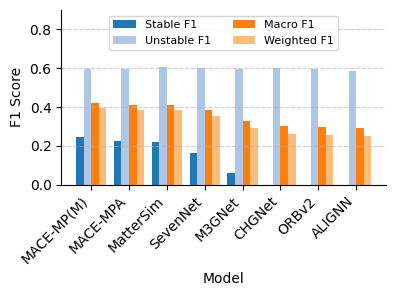

In [103]:
from matplotlib import cm

# Metrics and bar settings
metrics = ["Stable F1", "Unstable F1", "Macro F1", "Weighted F1"]
bar_width = 0.2
x = np.arange(len(summary_df))

# Get Set2 colormap (as RGBA)
cmap = plt.get_cmap("tab20")
colors = {metric: cmap(i) for i, metric in enumerate(metrics)}

with plt.style.context("default"):
    plt.rcParams.update(
        {
            "font.size": SMALL_SIZE,
            "axes.titlesize": MEDIUM_SIZE,
            "axes.labelsize": MEDIUM_SIZE,
            "xtick.labelsize": MEDIUM_SIZE,
            "ytick.labelsize": MEDIUM_SIZE,
            "legend.fontsize": SMALL_SIZE,
            "figure.titlesize": BIGGER_SIZE,
        }
    )

    fig, ax = plt.subplots(figsize=(4, 3), layout="constrained")

    # Bar positions
    positions = {
        "Stable F1": x - 1.5 * bar_width,
        "Unstable F1": x - 0.5 * bar_width,
        "Macro F1": x + 0.5 * bar_width,
        "Weighted F1": x + 1.5 * bar_width,
    }

    # Plot each metric with assigned color
    for metric, pos in positions.items():
        ax.bar(
            pos, summary_df[metric], width=bar_width, label=metric, color=colors[metric]
        )

    ax.set_xlabel("Model")
    ax.set_ylabel("F1 Score")
    # ax.set_title('F1 Scores by Model and Class')
    ax.set_xticks(x)
    ax.set_xticklabels(summary_df["Model"], rotation=45, ha="right")
    ax.legend(ncols=2, bbox_to_anchor=(0.5, 1), loc="upper center", fontsize=SMALL_SIZE)
    # ax.legend(ncols=2, fontsize=SMALL_SIZE)
    ax.spines[["top", "right"]].set_visible(False)
    plt.tight_layout()
    plt.ylim(0, 0.9)
    plt.grid(axis="y", linestyle="--", alpha=0.6)

    plt.savefig("c2db_f1_bar.pdf", bbox_inches="tight")
    plt.show()